### Import Libraries

In [2]:
import operator
from typing import Dict, List, Tuple, Union

import pandas as pd

from csgo.parser import DemoParser
import time
import json
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import matplotlib
from matplotlib import patches
import imageio

### Load In Demo Data

In [13]:
# Create the parser object.
# Set log=True above if you want to produce a logfile for the parser.

# The JSON for this game is in the repo
demo_filepath = "../../../videos/endpoint-vs-copenhagen-flames-m2-dust2.dem"

demo_parser = DemoParser(demofile = demo_filepath, demo_id = "END-CPH-Dust2", parse_rate=128)

# Parse the demofile, output results to a dictionary and a dataframe.
data = demo_parser.parse()
data_df = demo_parser.parse(return_type="df")

11:31:52 [INFO] Go version>=1.14.0
11:31:52 [INFO] Initialized CSGODemoParser with demofile /Users/adithyansujithkumar/Documents/Projects/fps/csgo_stuff/csgo/videos/endpoint-vs-copenhagen-flames-m2-dust2.dem
11:31:52 [INFO] Setting demo id to END-CPH-Dust2
11:31:52 [INFO] Setting parse rate to 128
11:31:52 [INFO] Setting trade time to 5
11:31:52 [INFO] Setting buy style to hltv
11:31:52 [INFO] Rollup damages set to False
11:31:52 [INFO] Parse frames set to True
11:31:52 [INFO] Running Golang parser from /Users/adithyansujithkumar/miniconda3/lib/python3.8/site-packages/csgo-0.1-py3.8.egg/csgo/parser/
11:31:52 [INFO] Looking for file at /Users/adithyansujithkumar/Documents/Projects/fps/csgo_stuff/csgo/videos/endpoint-vs-copenhagen-flames-m2-dust2.dem
11:32:05 [INFO] Wrote demo parse output to END-CPH-Dust2.json
11:32:05 [INFO] Reading in JSON from END-CPH-Dust2.json
11:32:05 [INFO] JSON data loaded, available in the `json` attribute to parser
11:32:05 [INFO] Successfully parsed JSON outp

### Calculate Tile Values

The main objective of my map control idea was to figure out how much space/control did each team have on the map spatially. This first implementation is a distance based idea. Each map in CS:GO has a set of navigation (nav) tiles, which collectively make up the navigable portions of the map. So, these nav tiles can be used to somewhat cluster player positions together. This allows us to have a set of nav tiles to describe the positioning of each team. Now we can calculate a BFS-based metric for the neighboring tiles to see how much each team "controls" that tile. The metric is calculated by running BFS from each tile for a max traversal length of n (10 for this notebook's example). Then, a tile's value can be represented as a function of the traversal length to get to it from the player's original nav tile. The function used in this notebook is $f_t(x) = x/10$ where x is the number of nav tiles traversed to get from a player's tile p to a tile t. Values for a tile are tracked in an array as it is possible for an array to get a value from multiple players' tiles if they are within n tiles to multiple players.

In [4]:
def tile_values_snapshot(ctTilesWanted, tTilesWanted, neighborInfo):
    """
    Purpose: Iteratively run BFS from each player's current nav tile to calculate the 
    tile values for the current timestep/snapshot
    
    Inputs:
    ctTilesWanted -> Python List of Nav Tile IDs where CT players are located
    tTilesWanted -> Python List of Nav Tile IDs where T players are located
    neighborInfo -> Dictionary where key is Nav Tile ID and value is list of IDs for its neighbors
    
    Outputs:
    Tuple containing two dictionaries (CTDict, TDict) where the key is a Nav Tile ID and the value
    is the tile's value for that specific team
    """
    
    funcCTIds = [str(i) for i in list(ctTilesWanted)]
    funcTIds = [str(i) for i in list(tTilesWanted)]

    ### Run BFS For CT Tiles
    ctDict = {}
    for curId in funcCTIds:
        startVal = 10
        stepsize = 1
        tilesSeen = set()
        stack = []
        startingNode = (curId, startVal)
        stack.append(startingNode)
        while stack[0][1] > 0:
            curId, curVal = stack.pop(0)
            if curId not in tilesSeen:
                tilesSeen.add(curId)
                curTileValues = ctDict.get(int(curId), ([]))
                curTileValues.append(curVal/startVal)
                ctDict[int(curId)] = (curTileValues)
                for neighbor in neighborInfo[curId]:
                    stack.append((neighbor, curVal - stepsize))


    ### Run BFS For T Tiles
    tDict = {}
    for curId in funcTIds:
        
        startVal = 10
        stepsize = 1
        tilesSeen = set()
        stack = []
        startingNode = (curId, startVal)
        stack.append(startingNode)
        while stack[0][1] > 0:
            curId, curVal = stack.pop(0)
            if curId not in tilesSeen:
                tilesSeen.add(curId)
                curTileValues = tDict.get(int(curId), ([]))
                curTileValues.append(curVal/startVal)
                tDict[int(curId)] = (curTileValues)
                for neighbor in neighborInfo[curId]:
                    stack.append((neighbor, curVal - stepsize))
                    
    return ctDict, tDict


#### Load in Nav Tile Transitions

In [5]:
# Nav tile transitions were calculated using the csgonavparse library
# https://github.com/pnxenopoulos/csgonavparse

filepath_cur = './de_dust_2_transitions.json'
# Opening JSON file
with open(filepath_cur) as json_file:
    data = json.load(json_file)

#### Calculate values

In [6]:
roundWanted = 5
roundCTTiles = list(data_df['PlayerFrames'][(data_df['PlayerFrames']['RoundNum'] == roundWanted) & (data_df['PlayerFrames']['Side'] == 'CT') & (data_df['PlayerFrames']['IsAlive'])].groupby(by = 'Second')['AreaID'].apply(list))
roundTTiles = list(data_df['PlayerFrames'][(data_df['PlayerFrames']['RoundNum'] == roundWanted) & (data_df['PlayerFrames']['Side'] == 'T') & (data_df['PlayerFrames']['IsAlive'])].groupby(by = 'Second')['AreaID'].apply(list))
tmpRoundSecArr = list(data_df['PlayerFrames'][(data_df['PlayerFrames']['RoundNum'] == roundWanted)]['Second'].unique())
#print(len(roundCTTiles), len(roundTTiles))
combinedRoundTiles = zip(roundCTTiles, roundTTiles)
tileValuesRound = [tile_values_snapshot(i, j, data) for i, j in combinedRoundTiles]



11:25:00 [INFO] Note: NumExpr detected 12 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
11:25:00 [INFO] NumExpr defaulting to 8 threads.


#### Load in Nav Tile Metadata

In [7]:
tileInfo = pd.read_csv('../../../csgo/data/nav/map_nav.csv')
tileInfo

,MapName,AreaId,AreaName,NorthWestX,NorthWestY,NorthWestZ,SouthEastX,SouthEastY,SouthEastZ,Connections,HidingSpots,EarliestOccupyTimeFirstTeam,EarliestOccupyTimeSecondTeam
0,de_ancient,152,Outside,260.60,642.80,-19.416094,280.60,627.80,18.666107,10,0,8.199903,15.538094
1,de_ancient,2559,MainHall,155.60,512.80,75.847092,160.60,502.80,72.037033,3,0,12.804793,13.120758
2,de_ancient,2748,Ruins,725.60,732.80,-29.636036,730.60,722.80,-15.349043,3,1,7.245784,19.397285
3,de_ancient,2835,Middle,540.60,477.80,65.784042,565.60,457.80,68.031197,2,1,13.451628,8.742879
4,de_ancient,2927,SideHall,315.60,507.80,103.918999,340.60,492.80,104.806747,2,0,15.876244,11.825044
...,...,...,...,...,...,...,...,...,...,...,...,...,...
10592,de_vertigo,4366,TSpawn,417.00,809.25,11488.031250,429.50,790.50,11488.031250,4,0,0.404472,17.929251
10593,de_vertigo,4446,Bridge,623.25,553.00,11501.278320,629.50,546.75,11488.031250,4,0,10.745050,16.382465
10594,de_vertigo,4490,BombsiteB,173.25,346.75,11776.031250,192.00,328.00,11776.031250,4,1,15.058154,8.052150
10595,de_vertigo,5000,ARamp,573.25,621.75,11573.395508,579.50,609.25,11560.895508,5,0,11.585015,14.865434


#### Calculate Extra Tile Data

In [8]:
curMapTile = tileInfo[(tileInfo['MapName'] == 'de_dust2')]
curMapTile['TileWidth'] = curMapTile['SouthEastX'] - curMapTile['NorthWestX']
curMapTile['TileHeight'] = curMapTile['NorthWestY'] - curMapTile['SouthEastY']
curMapTile['TileArea'] = curMapTile['TileWidth'] * curMapTile['TileHeight']
tileToArea = {}
for i in range(len(curMapTile)):
    tileToArea[curMapTile['AreaId'].iloc[i]] = curMapTile['TileArea'].iloc[i]
tileToArea

<ipython-input-8-687f5a07e86c>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  curMapTile['TileWidth'] = curMapTile['SouthEastX'] - curMapTile['NorthWestX']
<ipython-input-8-687f5a07e86c>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  curMapTile['TileHeight'] = curMapTile['NorthWestY'] - curMapTile['SouthEastY']
<ipython-input-8-687f5a07e86c>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cave

{4964: 64.56611157024815,
 6954: 96.84919008264494,
 5268: 64.56612293388413,
 8547: 64.5661172520663,
 8638: 96.84917303719023,
 1723: 2324.380158574382,
 1972: 2324.3802097107387,
 4218: 484.24588223140495,
 5049: 871.6425402892585,
 5217: 96.84918440082474,
 7575: 32.28306146694223,
 8209: 64.56611157024832,
 736: 64.56612861570262,
 739: 32.28305578512408,
 4052: 387.3966694214889,
 8671: 387.39670919421377,
 521: 32.28305578512392,
 3734: 5036.156986570247,
 7382: 96.84917303719006,
 9001: 129.132234504131,
 6726: 193.69834607438045,
 7525: 64.5661172520663,
 8081: 32.28306146694223,
 4939: 484.2458651859484,
 558: 32.28306146694223,
 1465: 484.2458822314033,
 3745: 193.6983460743798,
 8589: 22.127246997779967,
 6758: 32.28306714876105,
 6800: 645.6611668388426,
 7287: 32.28305578512424,
 8253: 192.46887411893104,
 8519: 64.56611725206646,
 1287: 2324.3801585743804,
 4044: 64.56611157024815,
 6581: 839.3594731404996,
 4371: 161.41528460743854,
 8026: 129.13222314049568,
 7231: 129

### Visualize Map Control Snapshot(s)

Now that we have values from the CT and T team for each tile, now we need to map these values to a color value for plotting. For this example we will use Red for T and Green for CT. There are 4 possible cases:
1.  a tile only has values from CT (within n tiles from at least one CT tile)
2. a tile only has values from T (within n tiles from at least 1 T tile)
3. a tile has values from both team (within n tiles from at least 1 T tile
4. and a tile doesn't have any values

If a tile only has values from one team, the max value is taken from its array of value. This max value is then mapped to a color by scaling the corresponding team's colors ([1, 0, 0] or [0, 1, 0] for this notebook) by the max value. Here's an example that might help. Let's say a tile T_0 has the following values [0.4, 0.8, 0.1] and all of these values were from the CT team. Then the max value for T_0 would be 0.8 and the color for the tile would be 0.8 * [0, 1, 0] = [0, 0.8, 0].

If a tile has values from both teams, the ratio between the sum of the CT values and the sum of both the CT and T values, or 

$$\frac{sum(Values_{CT})}{sum(Values_{CT}) + sum(Values_{T})}$$

Then, like before, this calculated value is linearly mapped to a color where 0 maps to [1, 0, 0] and 1 maps to [0, 1, 0].

In [9]:
def plot_map(map_name="de_dust2", map_type="original", dark=False):
    #Plots the simpleradar minimap for the wanted map. Code taken from csgo python library
    
    map_folder_path = "../../../csgo/data/map/"
    if map_type == "original":
        map_bg = plt.imread(map_folder_path + """{0}.png""".format(map_name))
    else:
        col = "light"
        if dark:
            col = "dark"
        map_bg = plt.imread(
            map_folder_path + """{0}_{1}.png""".format(map_name, col)
        )
    fig, ax = plt.subplots()
    ax.imshow(map_bg, zorder=0)
    return fig, ax

In [10]:
def plot_map_control_snapshot(tileData, ctTiles, tTiles, map_name = 'de_dust2'):
    """
    Purpose: Visualize map control for the current snapshot.
    Tile values are mapped to RGB colors and then plotted.
    
    Inputs:
    tileData -> Pandas df with nav tile metadata for the specific map
    
    ctTiles -> Dictionary mapping nav tile ID to its array of values
    from the CT team. Part of the output from tile_values_snapshot
    
    tTiles -> Dictionary mapping nav tile ID to its array of values
    from the T team. Part of the output from tile_values_snapshot
    
    map_name -> Name of map such that the correct minimap is plotted.
    Used for plot_map function
    
    Output(s):
    f, ax -> figure and axis objects used to visualize the current map control state
    """
    f, ax = plot_map(map_name = map_name, map_type = 'simpleradar', dark = True)
    ctTileLocs, tTileLocs = set(ctTiles.keys()), set(tTiles.keys())
    ctTileOnly, tTileOnly, bothTiles = ctTileLocs - tTileLocs, tTileLocs - ctTileLocs, ctTileLocs.intersection(tTileLocs)
    allRelevantTiles = ctTileLocs.union(tTileLocs)
    
    #iterate through the tiles that have a value
    for curTile in allRelevantTiles:
        func_cur_df = tileData[tileData['AreaId'] == curTile]
        func_cur_bl_x, func_cur_bl_y = func_cur_df['NorthWestX'].iloc[0], func_cur_df['SouthEastY'].iloc[0]
        func_cur_tr_x, func_cur_tr_y = func_cur_df['SouthEastX'].iloc[0], func_cur_df['NorthWestY'].iloc[0]
        func_curWidth, func_curHeight = func_cur_tr_x - func_cur_bl_x, func_cur_tr_y - func_cur_bl_y
        
        if curTile in ctTileLocs - tTileLocs:
            curTileValue = max(ctTiles[curTile])
            curColor = curTileValue * np.array([0, 1, 0])

        elif curTile in tTileLocs - ctTileLocs:
            curTileValue = max(tTiles[curTile])
            curColor = curTileValue * np.array([1, 0, 0])
            
        elif curTile in bothTiles:
            curTileValue = sum(ctTiles[curTile]) / (sum(ctTiles[curTile]) + sum(tTiles[curTile]))
            curColor = curTileValue * np.array([0, 1, 0]) + (1 - curTileValue) * np.array([1, 0, 0])
        rect = patches.Rectangle((func_cur_bl_x, func_cur_bl_y), func_curWidth, func_curHeight, linewidth=1, edgecolor= curColor, facecolor = curColor,  alpha = 1.0)
        ax.add_patch(rect)
    return f, ax



#### Visualize individual snapshot(s)

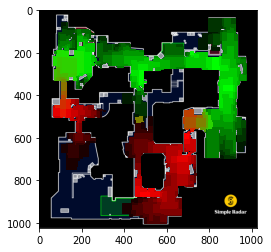

In [11]:
visIdx = 4
curF, curAx = plot_map_control_snapshot(curMapTile, tileValuesRound[visIdx][0], tileValuesRound[visIdx][1])

#### Generate Round Visualization GIF 

<ipython-input-9-16d360ff8635>:14: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


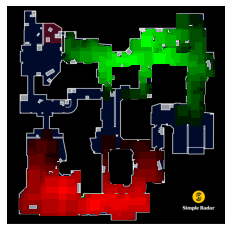

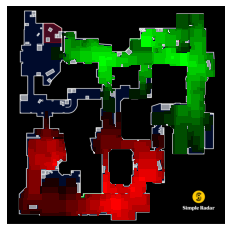

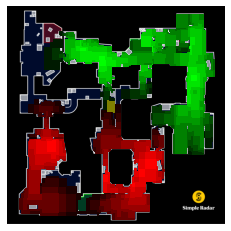

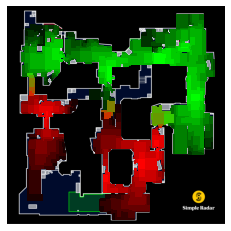

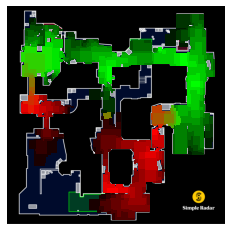

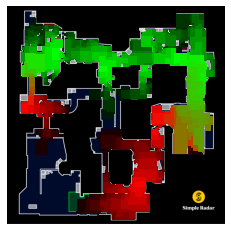

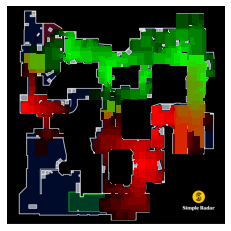

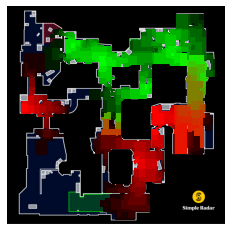

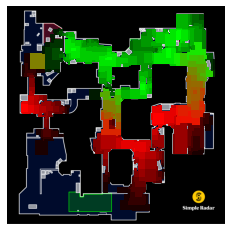

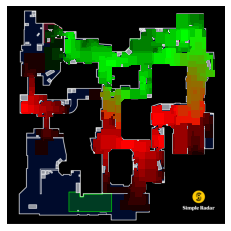

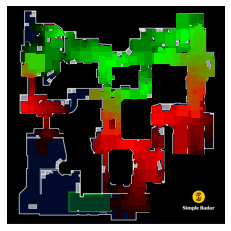

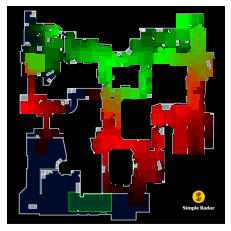

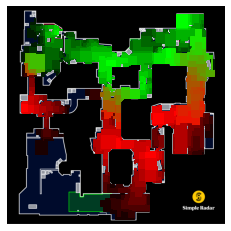

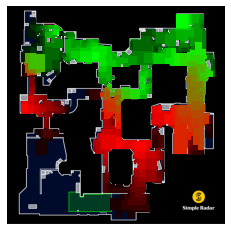

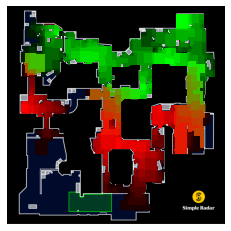

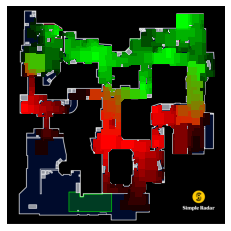

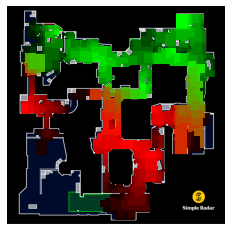

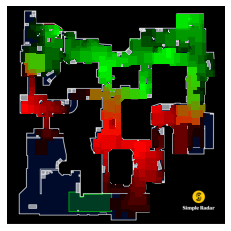

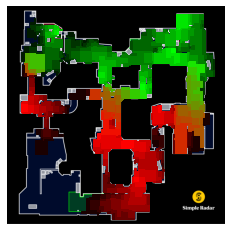

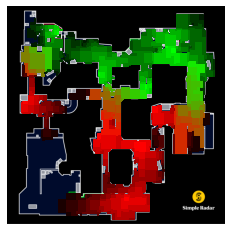

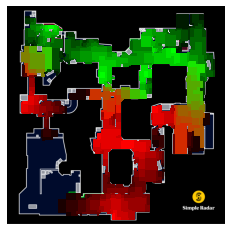

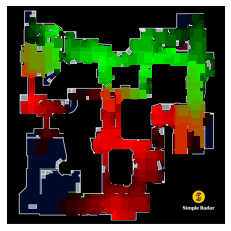

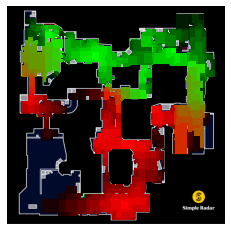

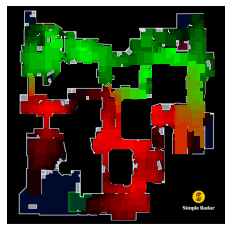

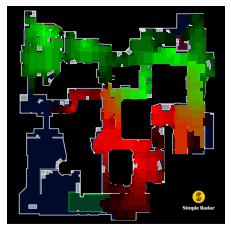

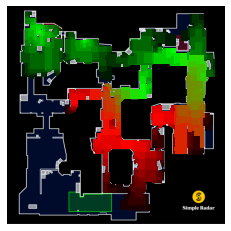

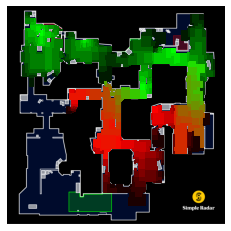

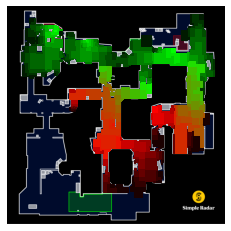

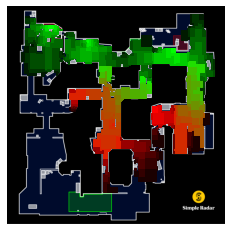

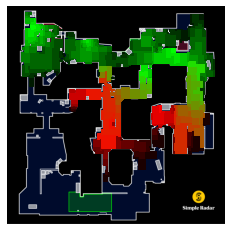

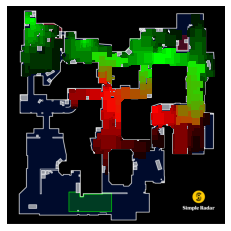

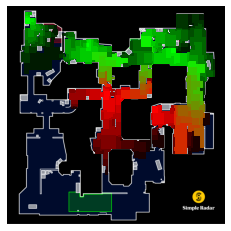

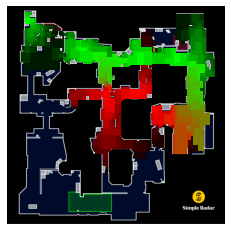

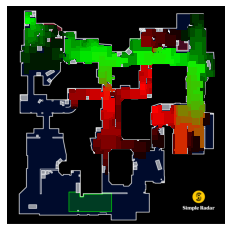

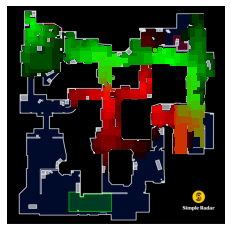

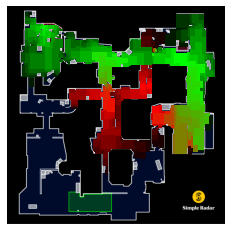

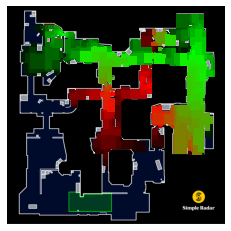

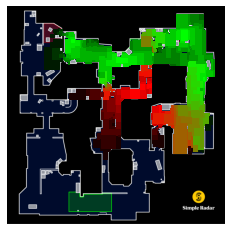

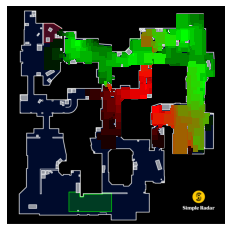

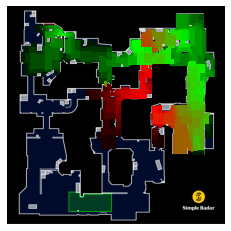

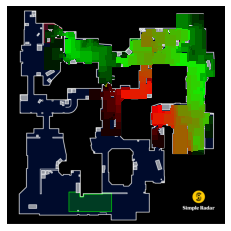

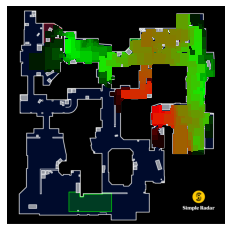

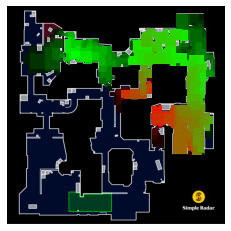

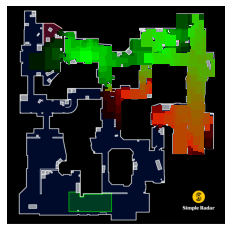

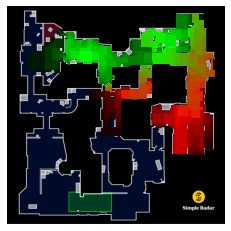

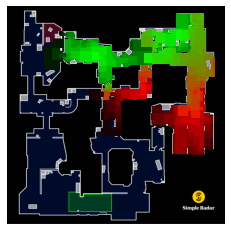

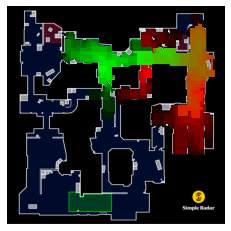

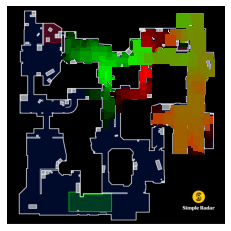

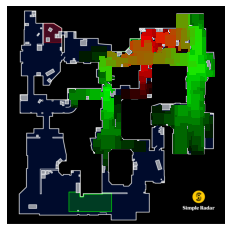

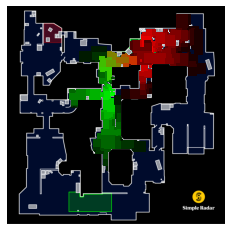

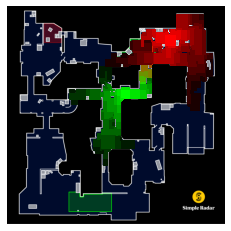

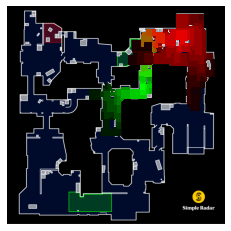

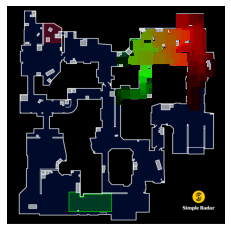

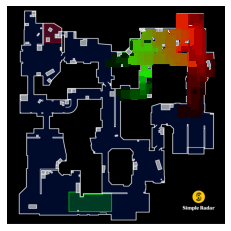

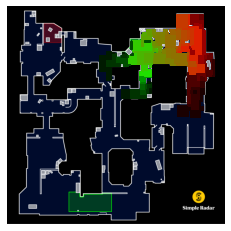

In [12]:
# create a temporary tmp folder where frames are going to be saved
# if you want a GIF of the round
    
for i in range(len(tileValuesRound)):
    curF, curAx = plot_map_control_snapshot(curMapTile, tileValuesRound[i][0], tileValuesRound[i][1])
    plt.axis('off')   
    curF.savefig(fname = './tmp/tmp_' + str(i) + '.png', bbox_inches='tight')


In [17]:
with imageio.get_writer('END-CPH-dust2-5.gif', mode='I') as writer:
    for i in range(len(tileValuesRound)):
        image = imageio.imread('./tmp/tmp_' + str(i) + '.png')
        writer.append_data(image)
